In [1]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
from scipy import stats
from scipy import optimize
from scipy.linalg import block_diag

from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

from typing import Union, List, Tuple

"""
Own packages
"""
from codelib.portfolio_optimization.risk_metrics import drawdown, maxdrawdown
from codelib.statistics.moments import corr_to_cov_matrix, cov_to_corr_matrix

from codelib.visualization.base import correlation_plot, fan_chart
from codelib.visualization.layout import DefaultStyle, default_colors
DefaultStyle();

from codelib.portfolio_optimization.black_litterman import calculate_capm_expected_return, calculate_bl_mu, calculate_bl_sigma
from codelib.portfolio_optimization.black_litterman import BlackLitterman

from codelib.portfolio_optimization.mean_variance import portfolio_variance

# Exercises - Week 10


## Problem 1:  Implementation of the Black-Litterman model

In this exercise, we will implement the Black-Litterman model in practice. 

__Question 1__

Obtain the Fama-French "12 industry portfolios" since 1999. Calculate the value weighted return index. What are the portfolio weights of each industry at the end of the sample?

__Question 2__

Calculate the average return for the industries. 

__Question 3__

Assume that $\lambda = 2.4$. Calculate the implied equilibrium expected returns. 

Is there a large difference compared to the ones calculated in question 2?

__Question 4__

We decide to implement the "extension" of the Black-Litterman model suggested by Meucci  (see [Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574)
). 

[Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574) suggests to simply set $\boldsymbol{\mu} = \boldsymbol{\pi}$ such that it is not a random variable and express our views directly on $\mathbf{R}$ using $\mathbf{P} \mathbf{R} = \mathbf{V}$ where we can think of the views as a random variable $\mathbf{V}$ with the conditional distribution 

$$
\mathbf{V} \vert \mathbf{r} \sim N(\mathbf{Pr}, \boldsymbol{\Omega})
$$

In practice, we will choose a specific value of $\mathbf{v}$. It is possible to show that 

$$
\mathbf{R} \vert \mathbf{v}, \boldsymbol{\Omega} \sim N(\boldsymbol{\mu}_{BL}^m, \boldsymbol{\Sigma}_{BL}^m)
$$

where 

\begin{align}
\boldsymbol{\mu}_{BL}^m &=  \boldsymbol{\pi} + \boldsymbol{\Sigma} \mathbf{P}^\top \left(\mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top + \boldsymbol{\Omega}\right)^{-1} (\mathbf{v} - \mathbf{P} \boldsymbol{\pi} ) \\
\boldsymbol{\Sigma}_{BL}^m &= \boldsymbol{\Sigma} - \boldsymbol{\Sigma} \mathbf{P}^\top \left(\mathbf{P}   \boldsymbol{\Sigma} \mathbf{P}^\top + \boldsymbol{\Omega} \right)^{-1} \mathbf{P} \boldsymbol{\Sigma}
\end{align}

Plot the market / reference distribution (probability density function) of the energy sector ('Enrgy').

__Qustion 5__

Implement the view that the Energy sector will return 20%. Consider three different confidence level $0.5, 1.0, 10.0$.

Plot the resulting distribution together with the reference distribution. What happens?

__Question 6__

Consider the views from above. How does the distribution of the telecom industry ('Telcm') change?

__Question 7__

Solve the minimization problem using the reference distribution 

$$
\underset{\mathbf{w}}{\text{arg min }} \mathbf{w}^\top \boldsymbol{\Sigma} \mathbf{w}
$$

subject to the budget constraint, a return target and positivity constraints

$$
\begin{align}
\mathbf{w}^\top \mathbf{1} &= 1 \\
\mathbf{w}^\top \boldsymbol{\mu} &= \bar{\mu}_p \\
w_i &\geq 0, \; i=1,..., N
\end{align}
$$

__Question 8__

Solve the minimization problem when assuming that: 

* The Energy sector will return 10%
* The Health Care sector ('Hlth') outperforms Durables sector ('Durbl') with 5%

Assume a confidence of 1.0. 

### Solution 

__Question 1__

In [2]:
reader = FamaFrenchReader("12_Industry_Portfolios", start=datetime.datetime(1999, 1, 1))
industry_port = reader.read()

# print description
industry_port['DESCR']

'12 Industry Portfolios\n----------------------\n\nThis file was created by CMPT_IND_RETS using the 202209 CRSP database. It contains value- and equal-weighted returns for 12 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2022 Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (285 rows x 12 cols)\n  1 : Average Equal Weighted Returns -- Monthly (285 rows x 12 cols)\n  2 : Average Value Weighted Returns -- Annual (23 rows x 12 cols)\n  3 : Average Equal Weighted Returns -- Annual (23 rows x 12 cols)\n  4 : Number of Firms in Portfolios (285 rows x 12 cols)\n  5 : Average Firm Size (285 rows x 12 cols)\n  6 : Sum of BE / Sum of ME (24 rows x 12 cols)\n  7 : Value-Weighted Average of BE/ME (24 rows x 12 cols)'

In [3]:
# get equally weighted
ind_eq_weighted = industry_port[1] / 100
ind_eq_weighted.columns = ind_eq_weighted.columns.str.strip()
#ind_eq_weighted.index = pd.to_datetime(ind_eq_weighted.index, format="%Y-%m")

# get market cap weighted 
ind_mc_weighted = industry_port[0] / 100
ind_mc_weighted.columns = ind_mc_weighted.columns.str.strip()
#ind_mc_weighted.index = pd.to_datetime(ind_mc_weighted.index, format="%Y%m")

# get number of companies in each sector
num_companies = industry_port[4]
num_companies.columns = num_companies.columns.str.strip()
#num_companies.index = pd.to_datetime(num_companies.index, format="%Y%m")

# get average firm size 
avg_firm_size = industry_port[5]
avg_firm_size.columns = avg_firm_size.columns.str.strip()
#avg_firm_size.index = pd.to_datetime(avg_firm_size.index, format="%Y%m")

# get sector market cap 
sector_mkt_cap  = num_companies * avg_firm_size
total_mkt_cap = sector_mkt_cap.sum(axis=1)

# get relative market cap
sector_mkt_cap_relative = sector_mkt_cap.divide(total_mkt_cap, axis="rows")

# calculate market return 
market_return = (sector_mkt_cap_relative * ind_mc_weighted).sum(axis="columns")

# calculate equal weighted return 
equal_weighted_return = (ind_mc_weighted / 12.0).sum(axis="columns")

# asset list
asset_list = ind_mc_weighted.columns

In [4]:
mkt_index = (1 + market_return).cumprod()

In [5]:
sector_mkt_cap_relative.tail(1)

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
Date,,,,,,,,,,,,
2022-09,0.041996,0.029899,0.052311,0.041385,0.025359,0.319317,0.02859,0.033571,0.101284,0.093764,0.137994,0.09453


In [6]:
w_m = sector_mkt_cap_relative.tail(1).values.flatten()

In [26]:
w_m

array([0.04199629, 0.02989873, 0.05231116, 0.04138533, 0.02535881,
       0.31931689, 0.02858964, 0.03357108, 0.10128419, 0.09376356,
       0.13799447, 0.09452986])

__Quesition 2__

In [27]:
asset_list

Index(['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils',
       'Shops', 'Hlth', 'Money', 'Other'],
      dtype='object')

In [7]:
# annualized hist. avg. returns
hist_returns = ind_mc_weighted.mean() * 12.0
hist_returns = hist_returns.values
hist_returns

array([0.08498526, 0.11536   , 0.10696   , 0.11178526, 0.08409684,
       0.10422316, 0.03998316, 0.08946526, 0.09658947, 0.08468211,
       0.07853474, 0.06744   ])

__Question 3__

In [8]:
# annualized covariance matrix
cov_mat = ind_mc_weighted.cov().values * 12.0

In [9]:
capm_returns = BlackLitterman.calculate_eq_expected_return(cov_mat, w_m, 2.4)
capm_returns

array([0.03430915, 0.09489067, 0.07223744, 0.05767011, 0.04533135,
       0.08762402, 0.05844139, 0.02680287, 0.05473827, 0.03832969,
       0.06595372, 0.06652688])

In [10]:
asset_list

Index(['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'Chems', 'BusEq', 'Telcm', 'Utils',
       'Shops', 'Hlth', 'Money', 'Other'],
      dtype='object')

__Question 4__



In [11]:
# specify Black-Litterman model (Meucci version) without any views
bl_model = BlackLitterman(cov_mat, capm_returns)

# calculate the posterior distribution (which should be the same as the reference distribution
# defined by cov_mat and pi (capm returns))
bl_model.calculate_posterior_distribution()

# Find the index of energy industry
idx_energy = np.where(asset_list=='Enrgy')[0][0]
idx_energy

3

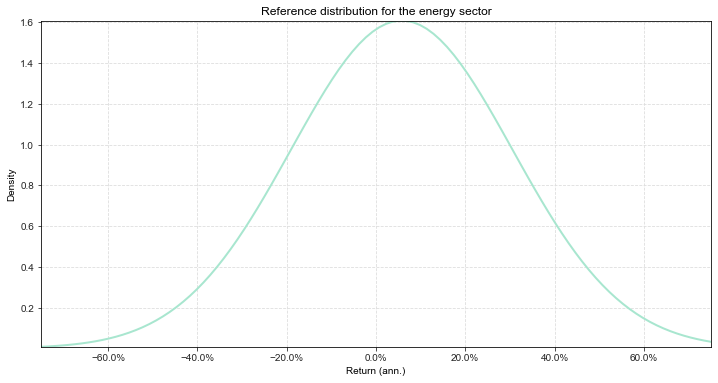

In [12]:
"""
Plot density of energy industry distribution 
"""
r_vals = np.linspace(-0.75, 0.75, 100)
mu_energy = bl_model.mean_posterior[idx_energy]
std_energy = np.sqrt(bl_model.cov_mat_posterior[idx_energy, idx_energy])
pdf_vals = stats.norm.pdf(r_vals, loc=mu_energy, scale=std_energy)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(r_vals, pdf_vals, label="Reference model")
ax.set_title("Reference distribution for the energy sector");
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));
ax.set_xlabel("Return (ann.)");
ax.set_ylabel("Density");

__Question 5__

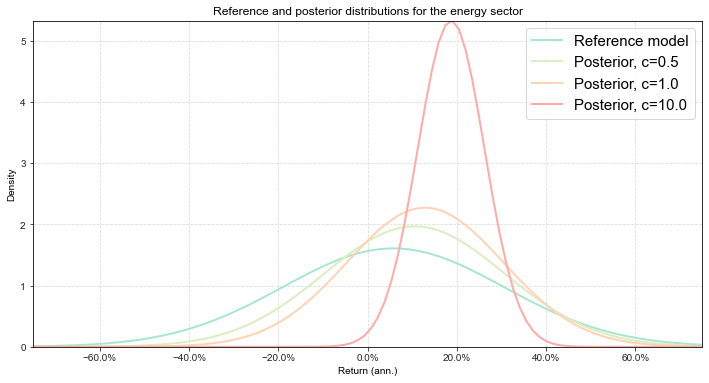

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(r_vals, pdf_vals, label="Reference model")

view = 0.2
for c in [0.5, 1.0, 10.0]:
    
    bl_model.clear_views()
    bl_model.add_equality_view(idx_energy, view)
    bl_model.calculate_posterior_distribution(confidence=c)
    
    mu_view = bl_model.mean_posterior[idx_energy]
    std_view = np.sqrt(bl_model.cov_mat_posterior[idx_energy, idx_energy])
    pdf_vals_view = stats.norm.pdf(r_vals, loc=mu_view, scale=std_view)
    
    ax.plot(r_vals, pdf_vals_view, label="Posterior, c={}".format(c))

ax.set_title("Reference and posterior distributions for the energy sector");
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));
ax.set_xlabel("Return (ann.)");
ax.set_ylabel("Density");
ax.legend();

__Question 6__

In [14]:
bl_model.clear_views()
bl_model.calculate_posterior_distribution()

# Find the index of telecom industry
idx_telecom = np.where(asset_list=='Telcm')[0][0]
idx_telecom

6

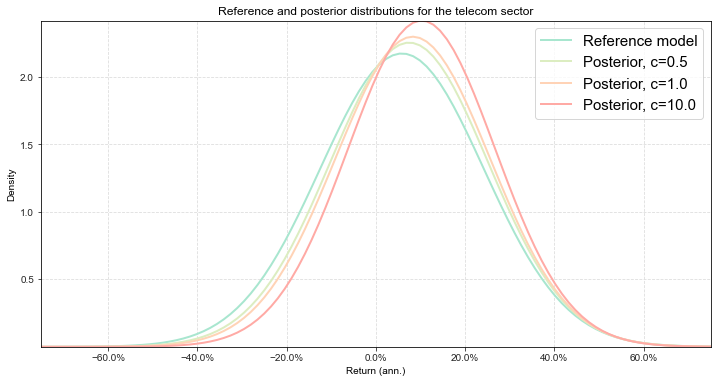

In [15]:
r_vals = np.linspace(-0.75, 0.75, 100)
mu_energy = bl_model.mean_posterior[idx_telecom]
std_energy = np.sqrt(bl_model.cov_mat_posterior[idx_telecom, idx_telecom])
pdf_vals = stats.norm.pdf(r_vals, loc=mu_energy, scale=std_energy)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(r_vals, pdf_vals, label="Reference model")

view = 0.2
for c in [0.5, 1.0, 10.0]:
    
    bl_model.clear_views()
    bl_model.add_equality_view(idx_energy, view)
    bl_model.calculate_posterior_distribution(confidence=c)
    
    mu_view = bl_model.mean_posterior[idx_telecom]
    std_view = np.sqrt(bl_model.cov_mat_posterior[idx_telecom, idx_telecom])
    pdf_vals_view = stats.norm.pdf(r_vals, loc=mu_view, scale=std_view)
    
    ax.plot(r_vals, pdf_vals_view, label="Posterior, c={}".format(c))

ax.set_title("Reference and posterior distributions for the telecom sector");
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1));
ax.set_xlabel("Return (ann.)");
ax.set_ylabel("Density");
ax.legend();

__Question 7__

In [16]:
bl_model.clear_views()
bl_model.calculate_posterior_distribution()

In [17]:
# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0, 
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

# alternatively use 
bounds = [(0.0, 1.0)] * len(bl_model.pi)

# set target returns
target_returns = np.linspace(0.03, 0.085, 100)

optimal_port_weights = []

x0 = np.ones_like(bl_model.pi) / len(bl_model.pi)

for target_return in target_returns: 
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ bl_model.mean_posterior - target_return,
                   'jac' : lambda x: bl_model.mean_posterior}
    
    res = optimize.minimize(portfolio_variance, x0=x0, args=(bl_model.cov_mat_posterior,),
                            method='SLSQP',
                            constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                            options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)

    optimal_port_weights.append(res.x)


optimal_port_weights = np.array(optimal_port_weights)


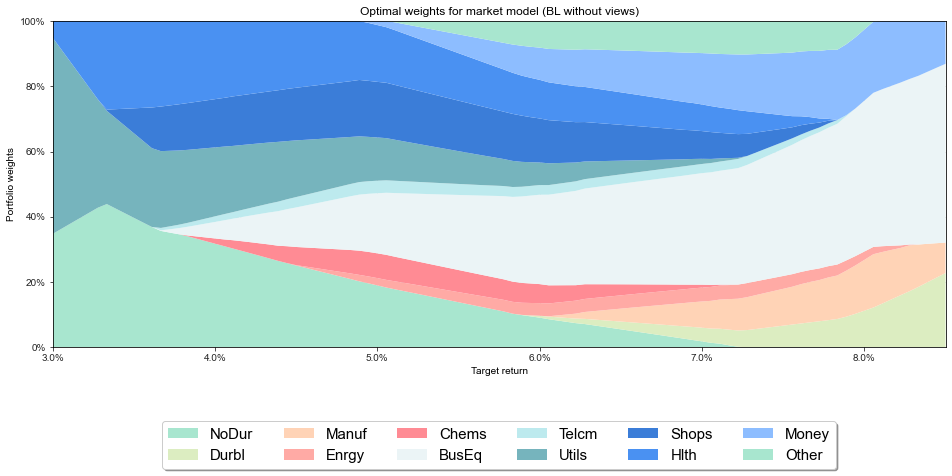

In [18]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(target_returns, optimal_port_weights.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Target return")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights for market model (BL without views)")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=6);

__Question 8__

In [19]:
idx_healthcare = np.where(asset_list=='Hlth')[0][0]
idx_durables = np.where(asset_list=='Durbl')[0][0]

In [20]:
bl_model.clear_views()
bl_model.add_equality_view(idx_energy, 0.1)
bl_model.add_diff_view(idx_healthcare, idx_durables, 0.05)

bl_model.calculate_posterior_distribution(confidence=1.0)

In [21]:
bl_model.mean_posterior

array([0.0361113 , 0.0507943 , 0.06442649, 0.07883505, 0.04383566,
       0.07519777, 0.05588184, 0.03262756, 0.044721  , 0.04751381,
       0.06043579, 0.05832129])

In [22]:
# define common constraints 
sum_to_one_cons = {'type': 'eq',
                   'fun' : lambda x: np.sum(x) - 1.0, 
                   'jac' : lambda x: np.ones_like(x)}

no_short_cons = {'type': 'ineq',
                 'fun' : lambda x: x,
                 'jac' : lambda x: np.eye(len(x))}

# alternatively use 
bounds = [(0.0, 1.0)] * len(bl_model.pi)

# set target returns
target_returns = np.linspace(0.03, 0.075, 100)

optimal_port_weights = []

x0 = np.ones_like(bl_model.pi) / len(bl_model.pi)

for target_return in target_returns: 
    
    # define constraint 
    target_cons = {'type': 'eq',
                   'fun' : lambda x: x @ bl_model.mean_posterior - target_return,
                   'jac' : lambda x: bl_model.mean_posterior}
    
    res = optimize.minimize(portfolio_variance, x0=x0, args=(bl_model.cov_mat_posterior,),
                            method='SLSQP',
                            constraints=[sum_to_one_cons, no_short_cons,  target_cons],  # no_short_cons,
                            options={'ftol': 1e-9, 'disp': False}) #, bounds=bounds)

    optimal_port_weights.append(res.x)


optimal_port_weights = np.array(optimal_port_weights)

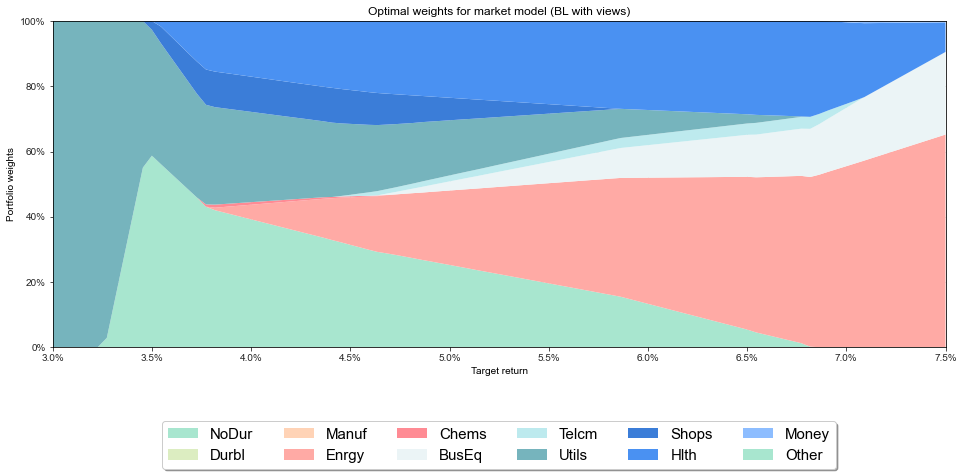

In [23]:
fig, ax = plt.subplots(figsize=(16, 6))


ax.stackplot(target_returns, optimal_port_weights.T, labels=asset_list);
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.set_xlabel("Target return")
ax.set_ylabel("Portfolio weights")
ax.set_title("Optimal weights for market model (BL with views)")
ax.legend(loc='center', bbox_to_anchor=(0.5, -0.3), fancybox=True, shadow=True, ncol=6);

In [24]:
corr_mat = cov_to_corr_matrix(cov_mat)

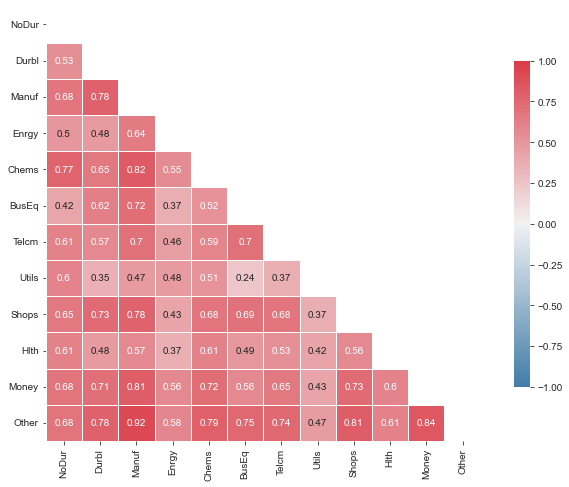

In [25]:
correlation_plot(corr_mat, names=asset_list, include_values=True)

fig = plt.gcf()

fig.set_size_inches((12, 8))

# References

## Articles

[Meucci (2008), "The Black-Litterman Approach: Original Model and Extensions"](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1117574)
